In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from astropy.modeling import models, fitting
from sklearn.model_selection import train_test_split

import calMetric
import calMetricOrigin


In [2]:
in_distribution = pd.read_csv("confidence_Our_In.txt", names=["T", "ε", "label", "score"])
out_distribution = pd.read_csv("confidence_Our_Out.txt", names=["T", "ε", "label", "score"])

train_in_distribution, test_in_distribution = train_test_split(in_distribution, train_size=0.8, test_size=0.2, shuffle=False)
train_out_distribution, test_out_distribution = train_test_split(out_distribution, train_size=0.8, test_size=0.2, shuffle=False)



In [3]:
train_in_distribution.describe()

,T,ε,label,score
count,8000.0,8.000000e+03,8000.000000,8000.000000
mean,1000.0,1.400000e-03,4.489125,0.102074
std,0.0,4.337080e-19,2.869871,0.000448
min,1000.0,1.400000e-03,0.000000,0.100695
25%,1000.0,1.400000e-03,2.000000,0.101765
50%,1000.0,1.400000e-03,4.000000,0.102084
75%,1000.0,1.400000e-03,7.000000,0.102385
max,1000.0,1.400000e-03,9.000000,0.103771


In [4]:
train_out_distribution.describe()

,T,ε,label,score
count,8000.0,8.000000e+03,8000.000000,8000.000000
mean,1000.0,1.400000e-03,4.110125,0.100829
std,0.0,4.337080e-19,2.775961,0.000254
min,1000.0,1.400000e-03,0.000000,0.100187
25%,1000.0,1.400000e-03,2.000000,0.100646
50%,1000.0,1.400000e-03,3.000000,0.100795
75%,1000.0,1.400000e-03,6.000000,0.100975
max,1000.0,1.400000e-03,9.000000,0.102299


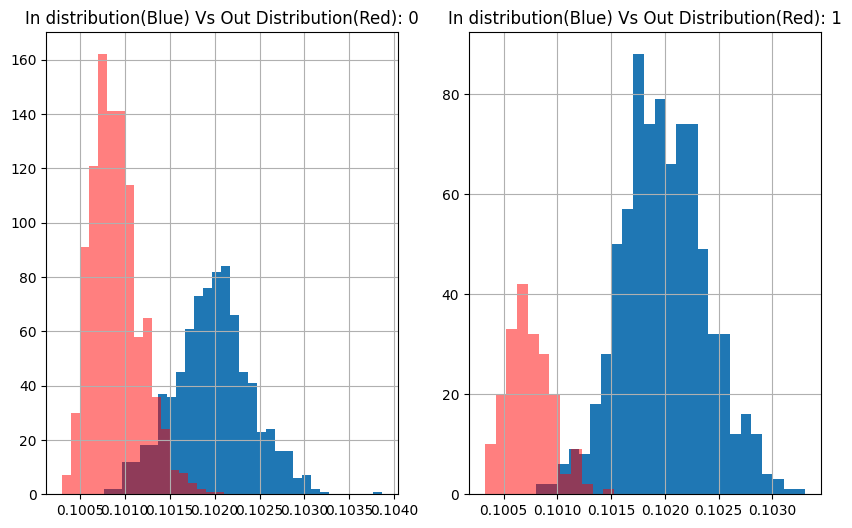

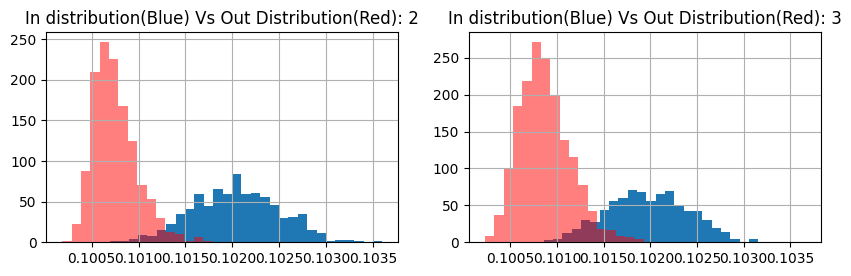

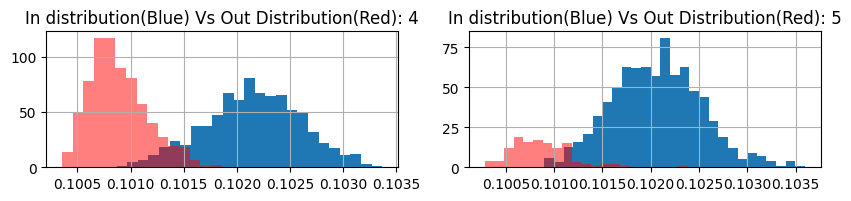

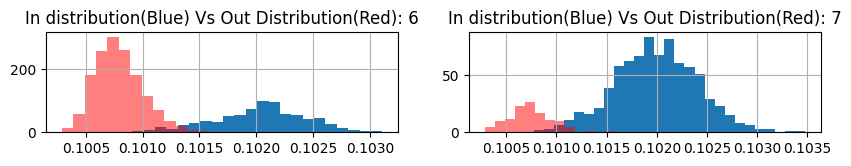

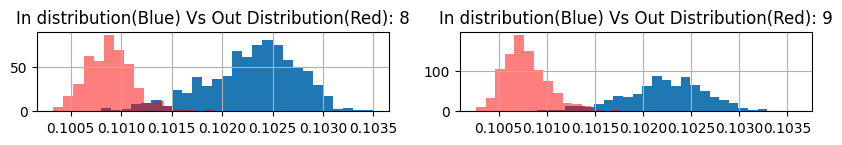

In [236]:
gm_mp = {}
labels = train_in_distribution["label"].drop_duplicates().sort_values()
binwidth=0.0001
for index, label in labels.items():
    # plot in distribution hist
    in_df = train_in_distribution.query("label == @label")["score"]    
    plt.figure((label // 2) + 1, figsize=(10,6))
    plt.subplot((label // 2) + 1, 2, (label % 2) + 1)
    plt.title("In distribution(Blue) Vs Out Distribution(Red): "  + str(label))  
    in_n, in_bins, in_patches = plt.hist(in_df, bins=np.arange(min(in_df), max(in_df) + binwidth, binwidth))
    
    # plot out distribution hist
    out_df = train_out_distribution.query("label == @label")["score"]
    plt.hist(out_df, bins=np.arange(min(out_df), max(out_df) + binwidth, binwidth), alpha=0.5, color="red")
    
    plt.grid(True)
    
    # build training data
    train_X = []  
    train_Y = [] 
    for i in range(len(in_patches)):
        train_X.append(in_bins[i] + binwidth / 2)
        train_Y.append(in_patches[i].get_height() / in_df.count())
                
    gm = fitting.LevMarLSQFitter()(models.Gaussian1D(amplitude=0.15, mean=0.102, stddev=0.0003), train_X, train_Y)
    gm_mp[label] = gm
    


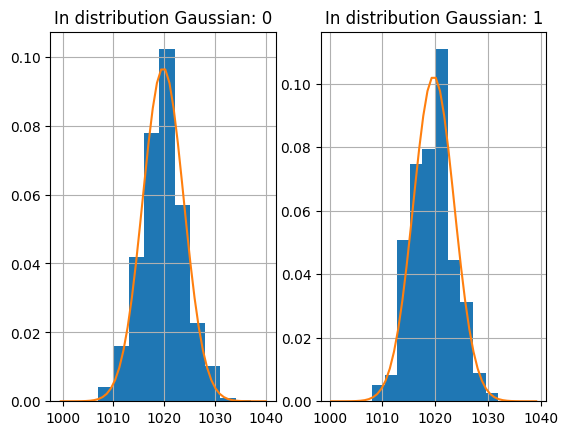

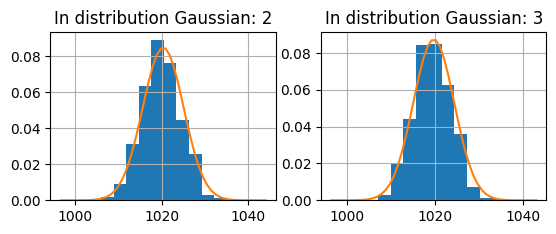

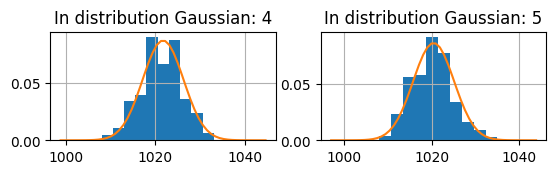

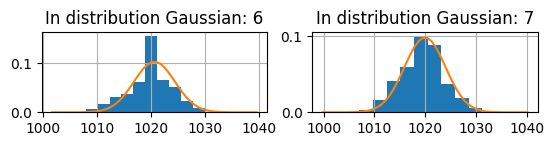

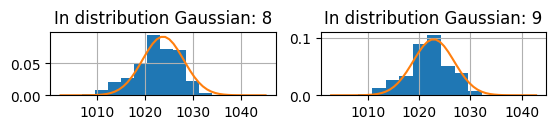

In [6]:
for label, gm in gm_mp.items():
    u = gm.mean.value
    sig = gm.stddev.value
    
    x = np.linspace(u - 5*sig, u + 5*sig, 50)
    # draw the Gaussian
    plt.figure((label // 2) + 1)
    plt.subplot((label // 2) + 1, 2, (label % 2) + 1)
    plt.title("In distribution Gaussian: "  + str(label))
   
    
    in_df = train_in_distribution.query("label == @label")["score"]
    in_df = (in_df * 10000).astype("int")
    
    plt.hist(in_df, density=True)
        
    
    plt.plot(x * 10000, gm(x))   
        
    plt.grid(True)

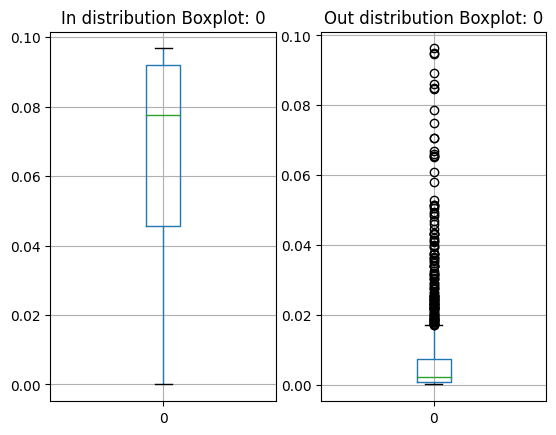

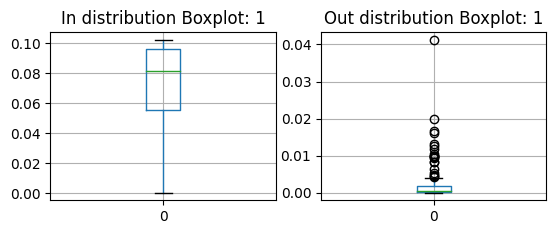

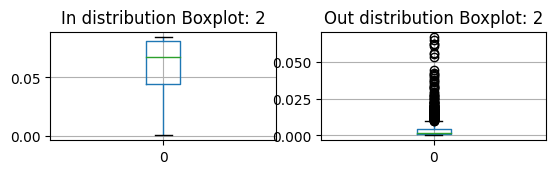

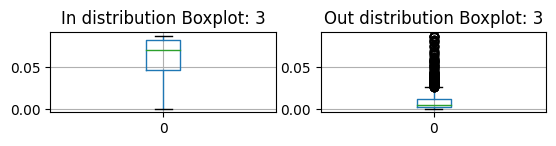

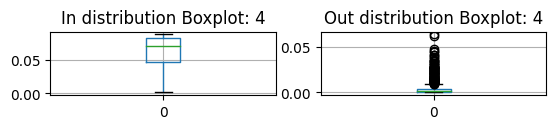

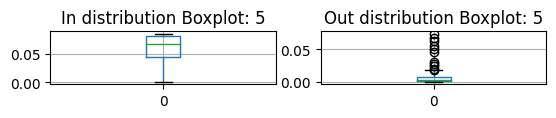

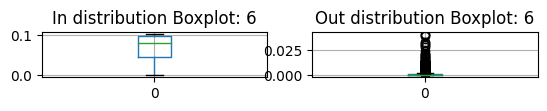

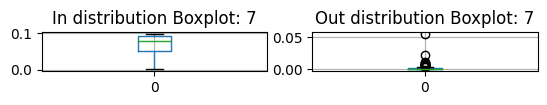

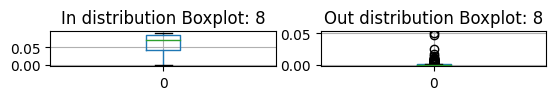

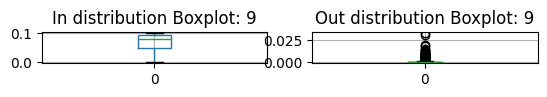

In [7]:
in_Y_list = []
out_Y_list = []
for label, gm in gm_mp.items():
    in_X = train_in_distribution.query("label == @label")["score"]
    in_Y = gm(in_X)
    out_X = train_out_distribution.query("label == @label")["score"]
    out_Y = gm(out_X)
    
    in_Y_list.extend(in_Y)
    out_Y_list.extend(out_Y)
    
    # draw the boxplot
    plt.figure(label + 1)
    plt.subplot(label + 1, 2, 1)
    plt.title("In distribution Boxplot: "  + str(label))    
    pd.DataFrame(in_Y).boxplot()
                
    plt.figure(label + 1)
    plt.subplot(label + 1, 2, 2)
    plt.title("Out distribution Boxplot: "  + str(label))  
    pd.DataFrame(out_Y).boxplot()    

In [8]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
display(pd.concat([pd.DataFrame(in_Y_list).rename(columns={0: "in distribution"}),
                   pd.DataFrame(out_Y_list).rename(columns={0: "out distribution"})], axis=1)
        .describe(percentiles=[i / 100 for i in range(10, 110, 10)]))
                 

,in distribution,out distribution
count,8000.00000,8000.00000
mean,0.06550,0.00471
std,0.02700,0.00983
min,0.00000,0.00000
10%,0.02258,0.00005
20%,0.03947,0.00017
30%,0.05317,0.00037
40%,0.06457,0.00068
50%,0.07348,0.00114
60%,0.08029,0.00191


In [9]:
# improve the running time
gm_score_mp = {}
for index, row in test_in_distribution.iterrows():
    label = row["label"]
    x = row["score"]
    y = gm_mp[label](x)
    if label not in gm_score_mp:
        gm_score_mp[label] = {}
    gm_score_mp[label][x] = y
    
for index, row in test_out_distribution.iterrows():
    label = row["label"]
    x = row["score"]
    y = gm_mp[label](x)
    if label not in gm_score_mp:
        gm_score_mp[label] = {}
    gm_score_mp[label][x] = y
    

for label, gm in gm_mp.items():
    gm_score_mp[label]["mean"] = gm.mean.value
    gm_score_mp[label]["stddev"] = gm.stddev.value
    

In [10]:
our_metric_dict = {}

for index, label in labels.items():
    # plot in distribution hist
    in_df = test_in_distribution.query("label == @label")
    out_df = test_out_distribution.query("label == @label")
    
    fpr = calMetric.tpr(in_df, out_df, gm_score_mp)
    error = calMetric.detection(in_df, out_df, gm_score_mp)
    auroc = calMetric.auRoc(in_df, out_df, gm_score_mp)
    auprin = calMetric.auprIn(in_df, out_df, gm_score_mp)
    auprout = calMetric.auprOut(in_df, out_df, gm_score_mp)
    
    
    print("label: " + str(label))
    print("in distribution sample cnt " + str(len(in_df)))
    print("out distribution sample cnt " + str(len(out_df)))
    
    print("{:20}{:13.1f}%".format("FPR:", fpr*100))
    print("{:20}{:13.1f}%".format("Detection error:", error*100))
    print("{:20}{:13.1f}%".format("AUROC:", auroc*100))
    print("{:20}{:13.1f}%".format("AUPR In:", auprin*100))
    print("{:20}{:13.1f}%".format("AUPR Out:", auprout*100))
    
    our_metric_dict[label] = {"fpr": fpr, "auc": auroc, 
                              "auprin": auprin, "auprout": auprout, "error": error}


label: 0
in distribution sample cnt 201
out distribution sample cnt 220
FPR:                          3.5%
Detection error:              5.0%
AUROC:                       98.9%
AUPR In:                     98.9%
AUPR Out:                    99.0%
label: 1
in distribution sample cnt 200
out distribution sample cnt 51
FPR:                          2.7%
Detection error:              4.0%
AUROC:                       99.1%
AUPR In:                     99.1%
AUPR Out:                    99.2%
label: 2
in distribution sample cnt 174
out distribution sample cnt 332
FPR:                          2.1%
Detection error:              2.6%
AUROC:                       99.6%
AUPR In:                     99.6%
AUPR Out:                    99.6%
label: 3
in distribution sample cnt 193
out distribution sample cnt 395
FPR:                          4.3%
Detection error:              6.0%
AUROC:                       98.4%
AUPR In:                     98.5%
AUPR Out:                    98.4%
label: 4
in d

In [11]:
base_metric_dict = {}
    
for index, label in labels.items():
    in_df = test_in_distribution.query("label == @label")
    out_df = test_out_distribution.query("label == @label")
    
    fpr = calMetricOrigin.tpr(in_df, out_df)
    error = calMetricOrigin.detection(in_df, out_df)
    auroc = calMetricOrigin.auRoc(in_df, out_df)
    auprin = calMetricOrigin.auprIn(in_df, out_df)
    auprout = calMetricOrigin.auprOut(in_df, out_df)
    
    base_metric_dict[label] = {"fpr": fpr, "auc": auroc, 
                              "auprin": auprin, "auprout": auprout, "error": error}

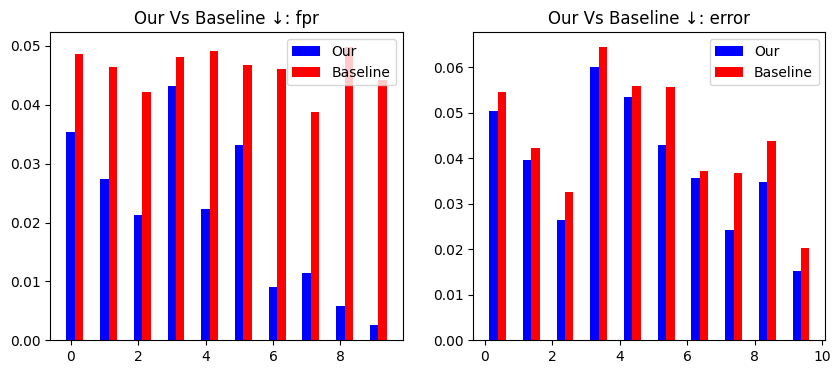

In [98]:
metric = ["fpr", "error"]

for m in range(len(metric)):
        
    plt.figure((m // 2) + 1, figsize=(10, 4))
    plt.subplot((m // 2) + 1, 2, (m % 2) + 1)
    plt.title("Our Vs Baseline ↓: "  + metric[m])
    y1 = []
    for index, label in labels.items():
        y1.append(our_metric_dict[label][metric[m]])
    plt.bar([i + m * 0.25  for i in range(0, 10)], y1, width = 0.25, color="blue", label="Our")
    
    y2 = []
    for index, label in labels.items():
        y2.append(base_metric_dict[label][metric[m]])
    plt.bar([i + (m + 1) * 0.25  for i in range(0, 10)], y2, width = 0.25, color="red", label="Baseline")
    plt.legend()
    
plt.show()

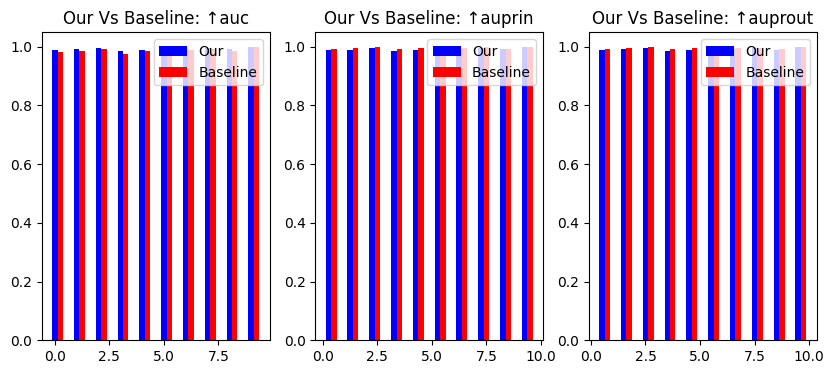

In [99]:
metric = ["auc", "auprin", "auprout"]

for m in range(len(metric)):
    plt.figure((m // 3) + 1, figsize=(10, 4))
    plt.subplot((m // 3) + 1, 3, (m % 3) + 1)
    plt.title("Our Vs Baseline: ↑"  + metric[m])
    y1 = []
    for index, label in labels.items():
        y1.append(our_metric_dict[label][metric[m]])
    plt.bar([i + m * 0.25  for i in range(0, 10)], y1, width = 0.25, color="blue", label="Our")
    
    y2 = []
    for index, label in labels.items():
        y2.append(base_metric_dict[label][metric[m]])
    plt.bar([i + (m + 1) * 0.25  for i in range(0, 10)], y2, width = 0.25, color="red", label="Baseline")
    plt.legend()
    
plt.show()

In [235]:
metric = ["fpr ↓", "error ↓", "auc ↑", "auprin ↑", "auprout ↑"]

our_metric = {}; baseline_metric = {}
for m in range(len(metric)):
    our = 0.0
    base = 0.0
    for index, label in labels.items():
        our += our_metric_dict[label][metric[m][0: -2]]
        base += base_metric_dict[label][metric[m][0: -2]]
    our = our / 10
    base = base / 10
    our_metric[metric[m].upper()] = round(our * 100, 2)
    baseline_metric[metric[m].upper()] = round(base * 100, 2)

o_df = pd.DataFrame.from_dict(our_metric, orient='index').rename(columns={0:"Our"})
b_df = pd.DataFrame.from_dict(baseline_metric, orient='index').rename(columns={0:"Baseline"})

m_df = pd.concat([o_df, b_df], axis = 1)
m_df["Different (Our - Baseline) / Base Line"] = round((m_df["Our"] - m_df["Baseline"]) / m_df["Baseline"] * 100, 2)


def color_difference(val): 
    if val > 0: 
        color = 'green'
    elif val < 0: 
        color = 'red'
    else:
        color = 'black'
    return 'color: %s' % color 



print("            With our improved method, \n" + 
      " FPR and Detection error are significantly reduced. \n" +
      " AUC, AUPR IN, AUPR OUT are almost same as Baseline. \n" +
      "The effectiveness of the improvement is demonstrated.")

m_df.style.applymap(color_difference, subset = ["Different (Our - Baseline) / Base Line"]).format('{:.2f}%')





            With our improved method, 
 FPR and Detection error are significantly reduced. 
 AUC, AUPR IN, AUPR OUT are almost same as Baseline. 
The effectiveness of the improvement is demonstrated.


,Our,Baseline,Different (Our - Baseline) / Base Line
FPR ↓,2.12%,4.60%,-53.91%
ERROR ↓,3.83%,4.44%,-13.74%
AUC ↑,99.21%,98.65%,0.57%
AUPRIN ↑,99.25%,99.58%,-0.33%
AUPROUT ↑,99.22%,99.57%,-0.35%
